# Pipeline API - Factor-Based Stock Screening

Zipline's Pipeline API is a powerful framework for:
- Defining reusable factors (momentum, value, quality, etc.)
- Screening large universes of stocks
- Building quantitative trading strategies
- Combining multiple factors

This notebook demonstrates how to use Pipeline to build a multi-factor strategy.

## Setup

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    pipeline_output,
    order_target_percent,
    record,
    schedule_function,
    date_rules,
    time_rules,
)
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import (
    SimpleMovingAverage,
    Returns,
    AverageDollarVolume,
)
from zipline.pipeline.filters import StaticAssets
from zipline.utils.progress import enable_progress_logging

# Enable logging
logging.basicConfig(level=logging.INFO, force=True)
enable_progress_logging(algo_name='Pipeline-Demo', update_interval=20)

## Define Custom Factors

Create reusable factors for stock selection.

In [3]:
class Momentum(CustomFactor):
    """
    Price momentum factor.
    Returns the % change over the lookback window.
    """
    inputs = [USEquityPricing.close]
    window_length = 60  # 60-day momentum
    
    def compute(self, today, assets, out, close):
        out[:] = (close[-1] - close[0]) / close[0]


class Volatility(CustomFactor):
    """
    Price volatility factor.
    Returns the standard deviation of returns.
    """
    inputs = [USEquityPricing.close]
    window_length = 20  # 20-day volatility
    
    def compute(self, today, assets, out, close):
        # Calculate daily returns
        returns = np.diff(close, axis=0) / close[:-1]
        # Calculate standard deviation
        out[:] = np.std(returns, axis=0)


print("✓ Custom factors defined")

✓ Custom factors defined


## Build Pipeline

Combine factors to screen stocks.

In [4]:
def make_pipeline():
    """
    Create a pipeline that:
    1. Calculates momentum and volatility
    2. Filters for liquid stocks (high dollar volume)
    3. Ranks stocks by momentum
    4. Selects top 5 high-momentum, low-volatility stocks
    """
    # Define universe: liquid stocks (top 500 by dollar volume)
    dollar_volume = AverageDollarVolume(window_length=30)
    liquid_stocks = dollar_volume.top(500)
    
    # Calculate factors
    momentum = Momentum()
    volatility = Volatility()
    
    # Combine factors:
    # Score = High momentum + Low volatility
    # Normalize each factor to z-scores for fair comparison
    momentum_z = momentum.zscore(mask=liquid_stocks)
    volatility_z = volatility.zscore(mask=liquid_stocks)
    
    # Combined score (high momentum, low volatility)
    combined_score = momentum_z - volatility_z  # Subtract vol (want low vol)
    
    # Select top stocks
    top_stocks = combined_score.top(5, mask=liquid_stocks)
    
    # Create pipeline
    pipe = Pipeline(
        columns={
            'momentum': momentum,
            'volatility': volatility,
            'combined_score': combined_score,
        },
        screen=top_stocks
    )
    
    return pipe

print("✓ Pipeline defined")

✓ Pipeline defined


## Strategy Implementation

Use pipeline output to trade.

In [5]:
def initialize(context):
    """
    Initialize strategy and attach pipeline.
    """
    # Attach pipeline
    pipe = make_pipeline()
    attach_pipeline(pipe, 'stock_screen')
    
    # Schedule rebalance monthly
    schedule_function(
        rebalance,
        date_rules.month_start(),
        time_rules.market_open(hours=1)
    )
    
    context.rebalance_count = 0
    
    logging.info("Pipeline strategy initialized")
    logging.info("  Rebalancing: Monthly")
    logging.info("  Universe: Top 500 liquid stocks")
    logging.info("  Selection: Top 5 by (momentum - volatility)")


def before_trading_start(context, data):
    """
    Called daily before market opens.
    Get pipeline output.
    """
    # Get pipeline output
    context.output = pipeline_output('stock_screen')


def rebalance(context, data):
    """
    Monthly rebalance based on pipeline output.
    """
    context.rebalance_count += 1
    
    # Get current pipeline output
    if context.output is None or context.output.empty:
        logging.warning("No stocks in pipeline output")
        return
    
    # Get selected stocks - FILTER OUT UNTRADEABLE ASSETS
    all_selected = context.output.index
    selected_stocks = [stock for stock in all_selected if data.can_trade(stock)]
    
    if len(selected_stocks) == 0:
        logging.warning("No tradeable stocks in pipeline output")
        return
    
    # Log if any stocks were filtered out
    if len(selected_stocks) < len(all_selected):
        filtered_out = [s.symbol for s in all_selected if s not in selected_stocks]
        logging.info(f"  Filtered out untradeable: {', '.join(filtered_out)}")
    
    # Equal weight
    target_weight = 1.0 / len(selected_stocks)
    
    # Get current positions
    current_positions = set(context.portfolio.positions.keys())
    
    # Sell stocks no longer in selection (only if tradeable)
    for stock in current_positions:
        if stock not in selected_stocks and data.can_trade(stock):
            order_target_percent(stock, 0.0)
    
    # Buy/rebalance selected stocks (already filtered for tradeability)
    for stock in selected_stocks:
        order_target_percent(stock, target_weight)
    
    # Log holdings
    holdings = [s.symbol for s in selected_stocks]
    logging.info(f"Rebalance #{context.rebalance_count}: {', '.join(holdings)}")
    
    # Log factor values (for tradeable stocks only)
    tradeable_output = context.output.loc[selected_stocks]
    if not tradeable_output.empty:
        logging.info(f"  Avg momentum: {tradeable_output['momentum'].mean():.2%}")
        logging.info(f"  Avg volatility: {tradeable_output['volatility'].mean():.4f}")


def handle_data(context, data):
    """
    Record daily metrics.
    """
    record(
        portfolio_value=context.portfolio.portfolio_value,
        num_positions=len(context.portfolio.positions),
        leverage=context.account.leverage,
    )

## Run Backtest

In [6]:
# Run backtest
results = run_algorithm(
    start=pd.Timestamp('2020-01-01'),
    end=pd.Timestamp('2023-12-31'),
    initialize=initialize,
    before_trading_start=before_trading_start,
    handle_data=handle_data,
    capital_base=100000,
    data_frequency='daily',
    bundle='sharadar',
)

print(f"\n✓ Backtest complete!")

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.


/root/.zipline/extension.py:56: UserWarning: Overwriting bundle with name 'sharadar'
  register('sharadar', sharadar_bundle())


2025-11-18 07:41:05,051 INFO zipline.progress: [Pipeline-Demo] Backtest initialized: 2020-01-02 to 2023-12-29 (1006 trading days)
2025-11-18 07:41:05,051 INFO zipline.progress: [Pipeline-Demo] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:root:Pipeline strategy initialized
INFO:root:  Rebalancing: Monthly
INFO:root:  Universe: Top 500 liquid stocks
INFO:root:  Selection: Top 5 by (momentum - volatility)
INFO:root:Rebalance #1: KRTX, BOLD1, AXSM, MDCO, ARWR
INFO:root:  Avg momentum: 232.06%
INFO:root:  Avg volatility: 0.0520


2025-11-18 07:41:06,341 INFO zipline.progress: [Pipeline-Demo] ----------      1%  2020-01-30             -1%         -0.29         -7%               $-955


INFO:root:Rebalance #2: DGAZF, SHOP, ITCI, TSLA, DXCM
INFO:root:  Avg momentum: 113.98%
INFO:root:  Avg volatility: 0.0309


2025-11-18 07:41:06,440 INFO zipline.progress: [Pipeline-Demo] ----------      3%  2020-02-28              2%          0.59        -10%               $2.1K


INFO:root:Rebalance #3: DGAZF, SPCE, TDOC, RNG, PCG
INFO:root:  Avg momentum: 112.67%
INFO:root:  Avg volatility: 0.0586


2025-11-18 07:41:06,540 INFO zipline.progress: [Pipeline-Demo] ----------      5%  2020-03-27             -4%         -0.01        -35%              $-3.9K


INFO:root:Rebalance #4: FTSV, VXX, VIXY, TVIXF, UVXY
INFO:root:  Avg momentum: 287.39%
INFO:root:  Avg volatility: 0.1594


2025-11-18 07:41:06,620 INFO zipline.progress: [Pipeline-Demo] ----------      7%  2020-04-27            -17%         -0.81        -35%             $-17.4K


INFO:root:Rebalance #5: VXX, VIXY, TVIXF, UVXY, INO
INFO:root:  Avg momentum: 235.63%
INFO:root:  Avg volatility: 0.0752


2025-11-18 07:41:06,702 INFO zipline.progress: [Pipeline-Demo] ----------      9%  2020-05-26            -20%         -0.75        -35%             $-20.2K


INFO:root:Rebalance #6: LVGO, DKNG, W, NVAX, IMMU
INFO:root:  Avg momentum: 155.33%
INFO:root:  Avg volatility: 0.0737


2025-11-18 07:41:06,857 INFO zipline.progress: [Pipeline-Demo] █---------     11%  2020-06-23             -9%         -0.10        -35%              $-9.2K


INFO:root:Rebalance #7: FSLY, WKHS, TOON, W, NVAX
INFO:root:  Avg momentum: 542.73%
INFO:root:  Avg volatility: 0.0813


2025-11-18 07:41:07,646 INFO zipline.progress: [Pipeline-Demo] █---------     13%  2020-07-22             -8%         -0.00        -35%              $-7.8K


INFO:root:Rebalance #8: SRNEQ, WKHS, ALT, BBBY, NVAX
INFO:root:  Avg momentum: 503.66%
INFO:root:  Avg volatility: 0.0859


2025-11-18 07:41:07,751 INFO zipline.progress: [Pipeline-Demo] █---------     15%  2020-08-19              7%          0.48        -35%               $6.9K


INFO:root:Rebalance #9: HYLN, NIO, WKHS, RUN, BBBY
INFO:root:  Avg momentum: 294.84%
INFO:root:  Avg volatility: 0.0669


2025-11-18 07:41:07,855 INFO zipline.progress: [Pipeline-Demo] █---------     17%  2020-09-17            -18%         -0.14        -43%             $-17.9K


INFO:root:Rebalance #10: GRWG, RUN, PENN, APPS, KODK
INFO:root:  Avg momentum: 184.61%
INFO:root:  Avg volatility: 0.0657


2025-11-18 07:41:07,964 INFO zipline.progress: [Pipeline-Demo] █---------     19%  2020-10-15            -16%         -0.04        -43%             $-15.9K


INFO:root:Rebalance #11: NIO, PLL, SPIEF, MYOK, JKS
INFO:root:  Avg momentum: 193.68%
INFO:root:  Avg volatility: 0.0641


2025-11-18 07:41:08,076 INFO zipline.progress: [Pipeline-Demo] ██--------     21%  2020-11-12            -20%         -0.09        -44%             $-19.8K


INFO:root:Rebalance #12: JMIA, NIO, SRRK, JKS, FCEL
INFO:root:  Avg momentum: 249.47%
INFO:root:  Avg volatility: 0.0923


2025-11-18 07:41:08,174 INFO zipline.progress: [Pipeline-Demo] ██--------     23%  2020-12-11            -17%         -0.00        -44%             $-17.3K


INFO:root:Rebalance #13: JMIA, MARA, RIOT, FCEL, QS
INFO:root:  Avg momentum: 456.51%
INFO:root:  Avg volatility: 0.1092


2025-11-18 07:41:08,280 INFO zipline.progress: [Pipeline-Demo] ██--------     25%  2021-01-12             37%          0.79        -44%              $37.2K


INFO:root:Rebalance #14: BNGO, JAGX, MARA, GME, FCEL
INFO:root:  Avg momentum: 1545.64%
INFO:root:  Avg volatility: 0.2504


2025-11-18 07:41:09,101 INFO zipline.progress: [Pipeline-Demo] ██--------     27%  2021-02-10             53%          0.90        -44%              $53.1K


INFO:root:Rebalance #15: BNGO, ZOMDF, SENS, OCGN, GEVO
INFO:root:  Avg momentum: 1417.62%
INFO:root:  Avg volatility: 0.1871


2025-11-18 07:41:09,205 INFO zipline.progress: [Pipeline-Demo] ██--------     29%  2021-03-11             48%          0.81        -44%              $47.6K


INFO:root:Rebalance #16: SOS, MI, AMC, MARA, GME
INFO:root:  Avg momentum: 849.71%
INFO:root:  Avg volatility: 0.2329


2025-11-18 07:41:09,320 INFO zipline.progress: [Pipeline-Demo] ███-------     31%  2021-04-09              2%          0.40        -44%               $2.1K


INFO:root:Rebalance #17: SHV, MI, GME, EL, WM
INFO:root:  Avg momentum: 341.97%
INFO:root:  Avg volatility: 0.0445


2025-11-18 07:41:09,429 INFO zipline.progress: [Pipeline-Demo] ███-------     33%  2021-05-07            -16%          0.20        -53%             $-16.2K


INFO:root:Rebalance #18: BNTX, AMC, PFPT, NUE, UPST
INFO:root:  Avg momentum: 127.03%
INFO:root:  Avg volatility: 0.0585


2025-11-18 07:41:09,531 INFO zipline.progress: [Pipeline-Demo] ███-------     35%  2021-06-07             -7%          0.30        -54%              $-6.9K


INFO:root:Rebalance #19: BNTX, MRNA, PBR, AMC, VTNRQ
INFO:root:  Avg momentum: 296.82%
INFO:root:  Avg volatility: 0.0552


2025-11-18 07:41:09,634 INFO zipline.progress: [Pipeline-Demo] ███-------     37%  2021-07-06            -20%          0.15        -54%             $-20.4K


INFO:root:Rebalance #20: MRNA, NTLA, AMC, MRINQ, ASAN
INFO:root:  Avg momentum: 228.52%
INFO:root:  Avg volatility: 0.0681


2025-11-18 07:41:10,507 INFO zipline.progress: [Pipeline-Demo] ███-------     39%  2021-08-03             -8%          0.28        -58%              $-8.4K
2025-11-18 07:41:10,604 INFO zipline.progress: [Pipeline-Demo] ████------     41%  2021-08-31              2%          0.37        -58%               $1.5K


INFO:root:Rebalance #21: TBIO1, TEAM, MSCI, SPRT, CMG
INFO:root:  Avg momentum: 195.43%
INFO:root:  Avg volatility: 0.0380


2025-11-18 07:41:10,702 INFO zipline.progress: [Pipeline-Demo] ████------     43%  2021-09-29             -5%          0.31        -58%              $-4.5K


INFO:root:Rebalance #22: TEAM, PANW, CEIN, HRC, UPST
INFO:root:  Avg momentum: 171.03%
INFO:root:  Avg volatility: 0.0401


2025-11-18 07:41:10,798 INFO zipline.progress: [Pipeline-Demo] ████------     45%  2021-10-27            -12%          0.24        -58%             $-12.0K


INFO:root:Rebalance #23: CAR, BKKT, ASAN, UPST, AFRM
INFO:root:  Avg momentum: 160.29%
INFO:root:  Avg volatility: 0.1434


2025-11-18 07:41:10,887 INFO zipline.progress: [Pipeline-Demo] ████------     47%  2021-11-24            -36%          0.01        -64%             $-35.5K


INFO:root:Rebalance #24: PHUN, CAR, BIOR, LCID, DJT
INFO:root:  Avg momentum: 206.68%
INFO:root:  Avg volatility: 0.0756


2025-11-18 07:41:10,988 INFO zipline.progress: [Pipeline-Demo] ████------     49%  2021-12-23            -54%         -0.20        -74%             $-53.6K


INFO:root:Rebalance #25: ANET, BLDR, CAR, LGVN, DJT
INFO:root:  Avg momentum: 170.95%
INFO:root:  Avg volatility: 0.0479


2025-11-18 07:41:11,833 INFO zipline.progress: [Pipeline-Demo] █████-----     51%  2022-01-24            -60%         -0.30        -77%             $-60.1K


INFO:root:Rebalance #26: CONE, ABBV, VRTX, CERN, SO
INFO:root:  Avg momentum: 17.21%
INFO:root:  Avg volatility: 0.0075


2025-11-18 07:41:11,927 INFO zipline.progress: [Pipeline-Demo] █████-----     53%  2022-02-22            -58%         -0.25        -78%             $-58.1K


INFO:root:Rebalance #27: AA, ZNGA, ATVI, HAL, DJT
INFO:root:  Avg momentum: 63.13%
INFO:root:  Avg volatility: 0.0239


2025-11-18 07:41:12,026 INFO zipline.progress: [Pipeline-Demo] █████-----     55%  2022-03-22            -58%         -0.24        -78%             $-58.0K


INFO:root:Rebalance #28: INDO, AR, OXY, ATVI, FHN
INFO:root:  Avg momentum: 185.88%
INFO:root:  Avg volatility: 0.0557


2025-11-18 07:41:12,126 INFO zipline.progress: [Pipeline-Demo] █████-----     57%  2022-04-20            -56%         -0.21        -78%             $-56.3K


INFO:root:Rebalance #29: PLAN, NLSN, AR, EQT, SWN
INFO:root:  Avg momentum: 62.17%
INFO:root:  Avg volatility: 0.0204


2025-11-18 07:41:12,235 INFO zipline.progress: [Pipeline-Demo] █████-----     59%  2022-05-18            -61%         -0.27        -78%             $-61.1K


INFO:root:Rebalance #30: PLAN, SAIL1, EPAM, VERU, EQT
INFO:root:  Avg momentum: 83.27%
INFO:root:  Avg volatility: 0.0443


2025-11-18 07:41:12,345 INFO zipline.progress: [Pipeline-Demo] ██████----     61%  2022-06-16            -60%         -0.24        -78%             $-59.8K


INFO:root:Rebalance #31: SQQQ, QID, PSQ, BIL, RDBX
INFO:root:  Avg momentum: 76.91%
INFO:root:  Avg volatility: 0.0589


2025-11-18 07:41:12,452 INFO zipline.progress: [Pipeline-Demo] ██████----     63%  2022-07-18            -62%         -0.27        -78%             $-62.0K


INFO:root:Rebalance #32: ENPH, SGEN, SNPS, MNST, LI
INFO:root:  Avg momentum: 32.15%
INFO:root:  Avg volatility: 0.0260


2025-11-18 07:41:13,311 INFO zipline.progress: [Pipeline-Demo] ██████----     65%  2022-08-15            -66%         -0.32        -81%             $-66.1K


INFO:root:Rebalance #33: GBT, CCXI, FSLR, ALNY, CAH
INFO:root:  Avg momentum: 88.66%
INFO:root:  Avg volatility: 0.0279


2025-11-18 07:41:13,421 INFO zipline.progress: [Pipeline-Demo] ██████----     67%  2022-09-13            -70%         -0.38        -83%             $-69.7K


INFO:root:Rebalance #34: GBT, FSLR, WOLF2, SGFY, CEG
INFO:root:  Avg momentum: 70.10%
INFO:root:  Avg volatility: 0.0162


2025-11-18 07:41:13,528 INFO zipline.progress: [Pipeline-Demo] ██████----     69%  2022-10-11            -71%         -0.39        -83%             $-70.9K


INFO:root:Rebalance #35: TBT, STOR, COP, MRO, APA
INFO:root:  Avg momentum: 36.46%
INFO:root:  Avg volatility: 0.0182


2025-11-18 07:41:13,635 INFO zipline.progress: [Pipeline-Demo] ███████---     71%  2022-11-08            -69%         -0.36        -84%             $-69.4K


INFO:root:Rebalance #36: ACGL, GILD, BIIB, ABMD, SLB
INFO:root:  Avg momentum: 39.79%
INFO:root:  Avg volatility: 0.0127


2025-11-18 07:41:13,747 INFO zipline.progress: [Pipeline-Demo] ███████---     73%  2022-12-07            -73%         -0.41        -84%             $-72.7K


INFO:root:Rebalance #37: BURL, HZNP, GILD, CAT, BA
INFO:root:  Avg momentum: 49.12%
INFO:root:  Avg volatility: 0.0196


2025-11-18 07:41:13,845 INFO zipline.progress: [Pipeline-Demo] ███████---     75%  2023-01-06            -72%         -0.39        -84%             $-71.9K


INFO:root:Rebalance #38: BILI, COUP, BURL, HZNP, MDGL
INFO:root:  Avg momentum: 135.75%
INFO:root:  Avg volatility: 0.0174


2025-11-18 07:41:14,690 INFO zipline.progress: [Pipeline-Demo] ███████---     77%  2023-02-06            -73%         -0.41        -84%             $-73.2K


INFO:root:Rebalance #39: KOLD, SPOT, WYNN, URI, GE
INFO:root:  Avg momentum: 77.59%
INFO:root:  Avg volatility: 0.0330


2025-11-18 07:41:14,788 INFO zipline.progress: [Pipeline-Demo] ███████---     79%  2023-03-07            -74%         -0.41        -85%             $-73.6K


INFO:root:Rebalance #40: FNGA, TSLA, NVDA, OSH, AI
INFO:root:  Avg momentum: 128.48%
INFO:root:  Avg volatility: 0.0382


2025-11-18 07:41:14,890 INFO zipline.progress: [Pipeline-Demo] ████████--     81%  2023-04-04            -71%         -0.35        -85%             $-70.9K


INFO:root:Rebalance #41: NVO, NVS, SGEN, GIS, OSH
INFO:root:  Avg momentum: 30.96%
INFO:root:  Avg volatility: 0.0078


2025-11-18 07:41:14,991 INFO zipline.progress: [Pipeline-Demo] ████████--     83%  2023-05-03            -73%         -0.39        -85%             $-73.4K


INFO:root:Rebalance #42: FNGA, ISEE, SMCI, FCNCA, RXDX
INFO:root:  Avg momentum: 87.08%
INFO:root:  Avg volatility: 0.0295


2025-11-18 07:41:15,070 INFO zipline.progress: [Pipeline-Demo] ████████--     85%  2023-06-01            -75%         -0.41        -85%             $-74.5K
2025-11-18 07:41:15,157 INFO zipline.progress: [Pipeline-Demo] ████████--     87%  2023-06-30            -73%         -0.37        -85%             $-73.0K


INFO:root:Rebalance #43: MDB, W, SMCI, RCL, NU
INFO:root:  Avg momentum: 91.16%
INFO:root:  Avg volatility: 0.0254


2025-11-18 07:41:15,936 INFO zipline.progress: [Pipeline-Demo] ████████--     89%  2023-07-31            -69%         -0.30        -85%             $-69.4K


INFO:root:Rebalance #44: CVNA, SMCI, CCL, PLTR, UPST
INFO:root:  Avg momentum: 280.22%
INFO:root:  Avg volatility: 0.0559


2025-11-18 07:41:16,040 INFO zipline.progress: [Pipeline-Demo] █████████-     91%  2023-08-28            -78%         -0.44        -88%             $-77.9K


INFO:root:Rebalance #45: VRT, NKLAQ, CVNA, RETA, XPEV
INFO:root:  Avg momentum: 121.50%
INFO:root:  Avg volatility: 0.0378


2025-11-18 07:41:16,142 INFO zipline.progress: [Pipeline-Demo] █████████-     93%  2023-09-26            -77%         -0.41        -88%             $-77.1K


INFO:root:Rebalance #46: VRT, HZNP, X, ATVI, AFRM
INFO:root:  Avg momentum: 33.86%
INFO:root:  Avg volatility: 0.0144


2025-11-18 07:41:16,228 INFO zipline.progress: [Pipeline-Demo] █████████-     95%  2023-10-24            -76%         -0.39        -88%             $-76.5K


INFO:root:Rebalance #47: TZA, SPLK, X, SGEN, SGOV
INFO:root:  Avg momentum: 31.92%
INFO:root:  Avg volatility: 0.0108


2025-11-18 07:41:16,321 INFO zipline.progress: [Pipeline-Demo] █████████-     97%  2023-11-21            -76%         -0.38        -88%             $-76.2K


INFO:root:Rebalance #48: CRWD, SNAP, SPLK, ALL, COIN
INFO:root:  Avg momentum: 37.45%
INFO:root:  Avg volatility: 0.0188


2025-11-18 07:41:16,421 INFO zipline.progress: [Pipeline-Demo] █████████-     99%  2023-12-20            -75%         -0.35        -88%             $-74.7K
2025-11-18 07:41:16,449 INFO zipline.progress: [Pipeline-Demo] ██████████    100%  2023-12-29            -74%         -0.33        -88%             $-74.0K


INFO:zipline.finance.metrics.tracker:Simulated 1006 trading days
 first open: 2020-01-02 14:30:00+00:00
 last close: 2023-12-29 21:00:00+00:00


2025-11-18 07:41:16,456 INFO zipline.progress: 
[Pipeline-Demo] ==================================================
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] Backtest Complete!
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] ==================================================
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] Trading Days:     1006
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] Total Return:     -74.01%
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] Sharpe Ratio:     -0.33
2025-11-18 07:41:16,457 INFO zipline.progress: [Pipeline-Demo] Max Drawdown:     -87.8%
2025-11-18 07:41:16,458 INFO zipline.progress: [Pipeline-Demo] Final Value:      $25,986
2025-11-18 07:41:16,458 INFO zipline.progress: [Pipeline-Demo] ==================================================


✓ Backtest complete!


## Analyze Results

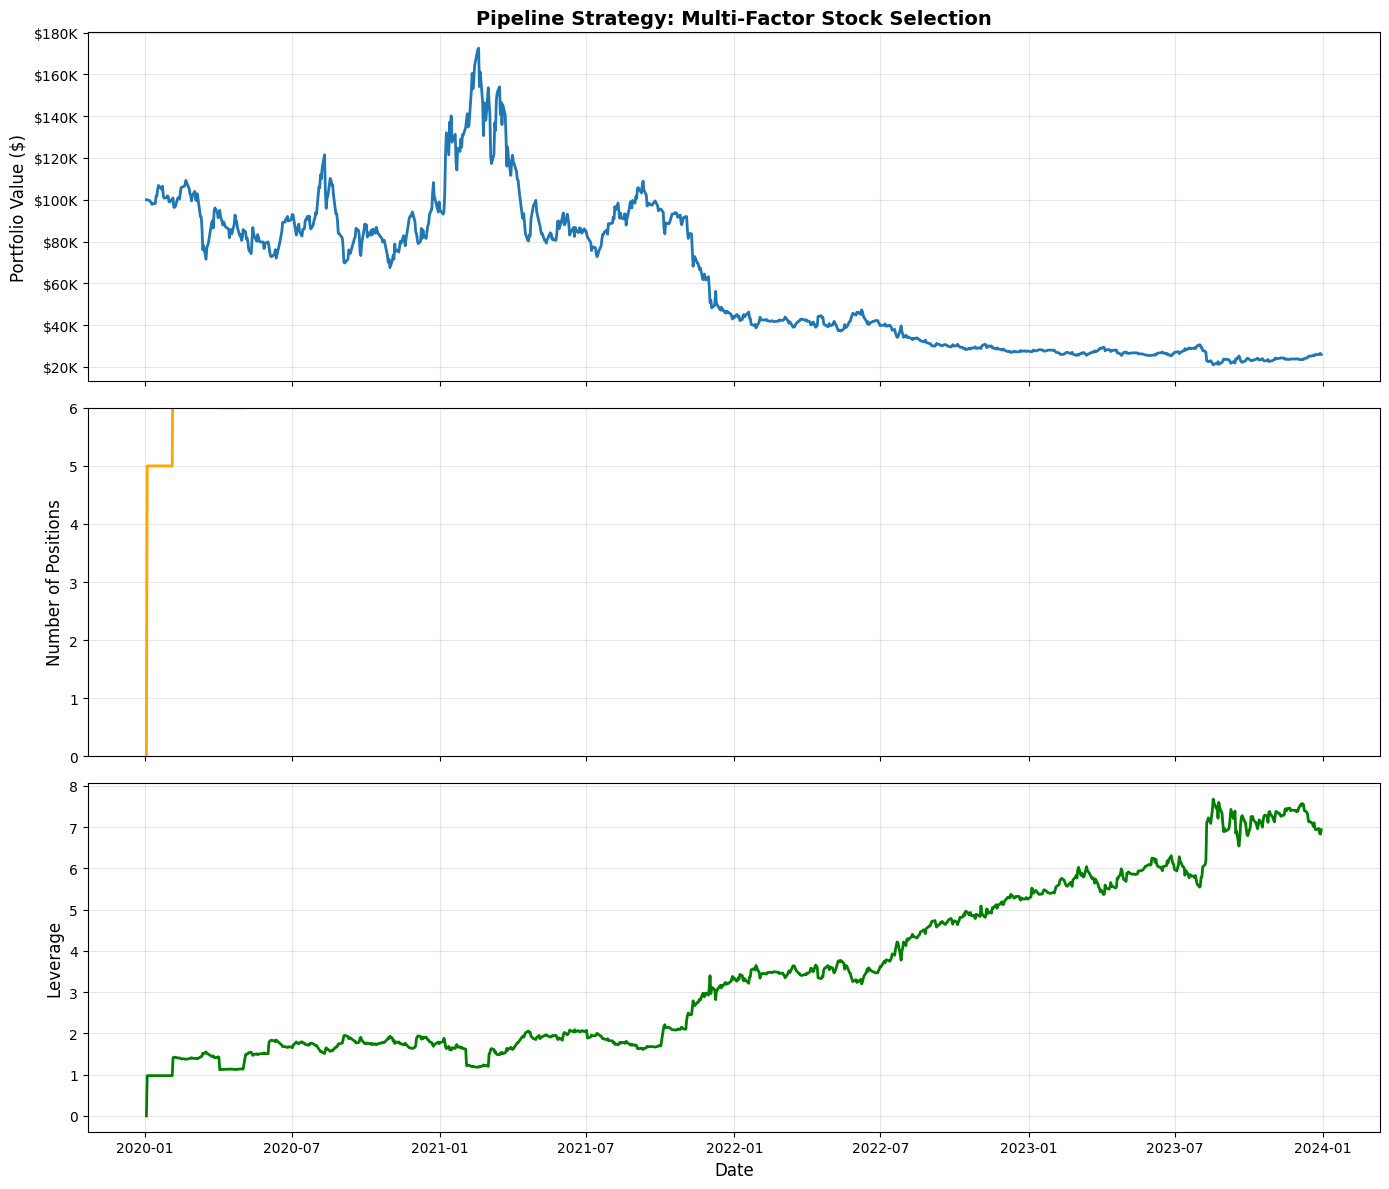


PERFORMANCE SUMMARY
Total Return: -74.01%
Sharpe Ratio: -0.33
Max Drawdown: -87.84%
Final Portfolio Value: $25,986.25
Avg Positions: 11.2


In [7]:
# Plot results
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Portfolio value
axes[0].plot(results.index, results['portfolio_value'], linewidth=2)
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].set_title('Pipeline Strategy: Multi-Factor Stock Selection', fontsize=14, fontweight='bold')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[0].grid(True, alpha=0.3)

# Number of positions
axes[1].plot(results.index, results['num_positions'], linewidth=2, color='orange')
axes[1].set_ylabel('Number of Positions', fontsize=12)
axes[1].set_ylim(0, 6)
axes[1].grid(True, alpha=0.3)

# Leverage
axes[2].plot(results.index, results['leverage'], linewidth=2, color='green')
axes[2].set_ylabel('Leverage', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics
total_return = ((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) - 1) * 100
daily_returns = results['portfolio_value'].pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
max_drawdown = ((results['portfolio_value'] / results['portfolio_value'].cummax()) - 1).min() * 100

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Total Return: {total_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print(f"Avg Positions: {results['num_positions'].mean():.1f}")
print("="*60)

## Holdings Analysis

In [8]:
# Analyze which stocks were held most frequently
all_holdings = {}
for date, row in results.iterrows():
    if row['positions']:
        for position in row['positions']:
            symbol = position['sid'].symbol
            all_holdings[symbol] = all_holdings.get(symbol, 0) + 1

if all_holdings:
    holdings_df = pd.DataFrame([
        {'Symbol': symbol, 'Days Held': days, 'Frequency': days/len(results)*100}
        for symbol, days in sorted(all_holdings.items(), key=lambda x: x[1], reverse=True)
    ])
    
    print("\nMost Frequently Held Stocks (Top 10):")
    print("="*60)
    print(holdings_df.head(10).to_string(index=False))
else:
    print("\nNo holdings to analyze.")


Most Frequently Held Stocks (Top 10):
Symbol  Days Held  Frequency
 BOLD1       1005  99.900596
  MDCO       1005  99.900596
  FTSV        943  93.737575
  MYOK        794  78.926441
 TBIO1        585  58.151093
  SPRT        585  58.151093
  PLAN        418  41.550696
   GBT        333  33.101392
  ABMD        270  26.838966
  COUP        229  22.763419


## Pipeline Testing (Standalone)

You can also run pipelines standalone to see what they output.

In [9]:
# Standalone pipeline execution is complex and requires specific setup
# The Pipeline API is primarily designed to work within run_algorithm()
# 
# For standalone research, consider using:
# - 07_pipeline_data_exploration.ipynb (uses pipeline within algorithm)
# - 08_alphalens_factor_analysis.ipynb (factor research workflow)
# - 09_multi_factor_research.ipynb (multi-factor analysis)
#
# These notebooks demonstrate how to extract and analyze pipeline data
# for research purposes without needing standalone pipeline execution.

print("\n" + "="*60)
print("PIPELINE RESEARCH WORKFLOW")
print("="*60)
print("\nFor factor research and pipeline exploration, see:")
print("  • 07_pipeline_data_exploration.ipynb")
print("  • 08_alphalens_factor_analysis.ipynb")
print("  • 09_multi_factor_research.ipynb")
print("\nThese notebooks show how to:")
print("  1. Run pipelines within backtests")
print("  2. Extract factor data for analysis")
print("  3. Evaluate factor performance with Alphalens")
print("  4. Test multi-factor combinations")
print("="*60)


PIPELINE RESEARCH WORKFLOW

For factor research and pipeline exploration, see:
  • 07_pipeline_data_exploration.ipynb
  • 08_alphalens_factor_analysis.ipynb
  • 09_multi_factor_research.ipynb

These notebooks show how to:
  1. Run pipelines within backtests
  2. Extract factor data for analysis
  3. Evaluate factor performance with Alphalens
  4. Test multi-factor combinations


## Advanced Pipeline Techniques

**Custom Factors:**
- Value factors (P/E, P/B, dividend yield)
- Quality factors (ROE, ROA, profit margins)
- Technical factors (RSI, MACD, Bollinger Bands)
- Sentiment factors (news, social media)

**Combining Factors:**
- Weighted combinations
- Quantile-based selection
- Factor neutralization
- Multi-factor rankings

**Advanced Screens:**
- Sector/industry filters
- Market cap constraints
- Liquidity requirements
- Correlation/covariance filters

## Next Steps

1. **Add more factors** - Implement value, quality, or technical factors
2. **Tune weights** - Optimize factor combinations
3. **Test sectors** - Apply to specific industries
4. **Compare periods** - Test in different market regimes
5. **Add constraints** - Maximum position sizes, sector limits

**Resources:**
- Zipline Pipeline docs: https://zipline.ml4trading.io/pipeline.html
- Factor research: AQR, Research Affiliates papers
- Quantitative value/momentum strategies